## Загрузка зависимостей

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
import warnings
import pickle
import os

warnings.filterwarnings('ignore')


# DATA_PATH = "../../data/clean_data.500k.csv"
DATA_PATH = "../../data/clean_data.csv"
SAVE_DIR = "../../data/graph-save"
OBSERVATION_DAYS = 30
PREDICTION_DAYS = 31

## Data split

In [2]:

def create_temporal_dataset(
    df,
    observation_days=30,
    prediction_days=31
):
    df = df.copy()
    df["event_dt"] = pd.to_datetime(df["event_dt"])

    max_date = df["event_dt"].max()
    min_date = df["event_dt"].min()

    observation_end = max_date - pd.Timedelta(days=prediction_days)
    observation_start = observation_end - pd.Timedelta(days=observation_days)

    if observation_start < min_date:
        observation_start = min_date

    print(f"\nObservation: {observation_start.date()} → {observation_end.date()}")
    print(f"Prediction: {observation_end.date()} → {max_date.date()}")

    # --- данные окна наблюдения ---
    observation_data = df[
        (df["event_dt"] >= observation_start) &
        (df["event_dt"] < observation_end)
    ].copy()

    # --- device_id set (появились хотя бы раз до prediction window) ---
    device_id_set = set(
        df[df["event_dt"] < observation_end]["device_id"].unique()
    )

    print(f"Nodes in observation: {observation_data['node_id'].nunique():,}")
    print(f"Devices before prediction: {len(device_id_set):,}")

    # --- таргеты по node_id (берём как есть) ---
    node_labels = (
        observation_data
        .groupby("node_id")["is_churn"]
        .max()          # если у node были разные события — churn=True побеждает
        .to_dict()
    )

    return observation_data, node_labels, device_id_set


def create_unified_split(node_labels, save_dir):
    node_ids = list(node_labels.keys())
    labels = [node_labels[nid] for nid in node_ids]

    train_val_ids, test_ids, train_val_labels, test_labels = train_test_split(
        node_ids,
        labels,
        test_size=0.2,
        random_state=42,
        stratify=labels
    )

    train_ids, val_ids, train_labels, val_labels = train_test_split(
        train_val_ids,
        train_val_labels,
        test_size=0.25,
        random_state=42,
        stratify=train_val_labels
    )

    split_data = {
        "train_ids": train_ids,
        "val_ids": val_ids,
        "test_ids": test_ids,
        "train_labels": train_labels,
        "val_labels": val_labels,
        "test_labels": test_labels,
    }

    os.makedirs(save_dir, exist_ok=True)
    with open(os.path.join(save_dir, "data_split.pkl"), "wb") as f:
        pickle.dump(split_data, f)

    print(
        f"\nSplit:"
        f" Train {len(train_ids):,}"
        f" | Val {len(val_ids):,}"
        f" | Test {len(test_ids):,}"
    )

    return split_data

## Baseline

In [3]:
import pandas as pd
import numpy as np


def extract_node_baseline_features(df, device_id_set):
    df = df.copy()
    df["event_dt"] = pd.to_datetime(df["event_dt"])

    # --- фильтрация по device_id_set ---
    df = df[df["device_id"].isin(device_id_set)].copy()

    # ============================================================
    # steps_count
    # ============================================================
    steps_count = (
        df.groupby("node_id")
        .size()
        .rename("steps_count")
    )

    # ============================================================
    # sessions_count (уникальные device_id + session_id)
    # ============================================================
    sessions_count = (
        df.groupby("node_id")[["device_id", "session_id"]]
        .apply(lambda x: x.drop_duplicates().shape[0])
        .rename("sessions_count")
    )

    # ============================================================
    # steptime_ms
    # ============================================================
    df = df.sort_values(["device_id", "session_id", "event_dt"])

    df["next_event_dt"] = (
        df.groupby(["device_id", "session_id", "node_id"])["event_dt"]
        .shift(-1)
    )

    df["steptime_ms"] = (
        (df["next_event_dt"] - df["event_dt"])
        .dt.total_seconds() * 1000
    )

    steptime = (
        df.groupby("node_id")["steptime_ms"]
        .mean()
        .rename("steptime_ms")
    )

    # ============================================================
    # feature_diversity_avg
    # ============================================================
    feature_diversity_avg = (
        df.groupby(["node_id", "device_id"])["feature"]
        .nunique()
        .groupby("node_id")
        .mean()
        .rename("feature_diversity_avg")
    )

    # ============================================================
    # age_avg
    # ============================================================
    age_avg = (
        df.groupby("node_id")["age"]
        .mean()
        .rename("age_avg")
    )

    # ============================================================
    # male_rate
    # ============================================================
    gender_df = df[df["gender"].notna()]

    male_rate = (
        gender_df.groupby("node_id")["gender"]
        .apply(lambda x: (x == "М").mean())
        .rename("male_rate")
    )

    # ============================================================
    # churn_rate
    # ============================================================
    churn_rate = (
        df.groupby("node_id")["is_churn"]
        .mean()
        .rename("churn_rate")
    )

    # ============================================================
    # объединение
    # ============================================================
    features = pd.concat(
        [
            steps_count,
            sessions_count,
            steptime,
            feature_diversity_avg,
            age_avg,
            male_rate,
            churn_rate,
        ],
        axis=1,
    )

    return features.reset_index()


## Семантический вектор (TF-IDF).

**Что именно делаем**:

1. Формируем текстовое описание ноды — это конкатенация:
    - screen
    - feature
    - action
2. Берём одно значение для каждой node_id (все события ноды — одинаковые).
3. Генерируем TF-IDF вектора.
4. Присоединяем их к node_features.

In [4]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

def build_node_text_embeddings(df: pd.DataFrame, max_features: int = 64):
    """
    На вход: события (event-level) df.
    На выход: DataFrame с колонкой 'text_embedding' (np.array(dtype=float)),
              index=node_id.
    
    Требуемые колонки:
    'node_id', 'screen', 'feature', 'action'
    """

    required = {'node_id', 'screen', 'feature', 'action'}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Missing columns: {missing}")

    # --- 1. Формируем текст для каждой строки ---
    df = df.copy()
    df['node_text'] = (
        df['screen'].astype(str) + " " +
        df['feature'].astype(str) + " " +
        df['action'].astype(str)
    )

    # --- 2. Выбираем одно представление на ноду ---
    node_text = (
        df.groupby('node_id')['node_text']
        .agg(lambda s: s.iloc[0])  # достаточно первой строки
    )

    # --- 3. TF-IDF ---
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        stop_words=None,
        lowercase=True
    )
    X = vectorizer.fit_transform(node_text.tolist())

    # --- 4. Конверт в numpy и DataFrame ---
    emb = pd.DataFrame(
        list(X.toarray()),
        index=node_text.index,
        columns=[f"tfidf_{i}" for i in range(X.shape[1])]
    )

    # Можно оставить как вектора
    emb['text_embedding'] = emb.apply(lambda row: row.values.astype(float), axis=1)

    return emb[['text_embedding']], vectorizer


In [5]:
def include_semantic_feature(df, features, save_dir):

    # после загрузки исходных событий
    text_emb, vectorizer = build_node_text_embeddings(df)

    # Объединение
    features = pd.merge(features, text_emb, on='node_id', how='left')

    import pickle

    # В первом ноутбуке - сохраняем
    def save_vectorizer(vectorizer, filename='tfidf_vectorizer.pkl'):
        with open(filename, 'wb') as f:
            pickle.dump(vectorizer, f)
        print(f"Vectorizer сохранен в {filename}")
        print(f"Параметры: max_features={vectorizer.max_features}, vocab size={len(vectorizer.vocabulary_)}")

    # Сохранение
    save_vectorizer(vectorizer, os.path.join(save_dir, 'tfidf_vectorizer.pkl'))
    return features


## GNN (node-level regression)

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv


class GraphSAGEChurn(nn.Module):
    """
    Node-level regression:
    y = churn_rate
    """
    def __init__(self, in_channels, hidden_channels=128, num_layers=2, dropout=0.3):
        super().__init__()

        self.convs = nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))

        for _ in range(num_layers - 1):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))

        self.dropout = dropout

        self.regressor = nn.Sequential(
            nn.Linear(hidden_channels, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1)
        )

    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i < len(self.convs) - 1:
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout, training=self.training)

        out = self.regressor(x)
        return out.squeeze(-1)   # [num_nodes]


## Обучение

In [47]:
import os
import numpy as np
import torch
from sklearn.metrics import mean_absolute_error, root_mean_squared_error


def train_gnn(
    data,
    train_mask,
    val_mask,
    test_mask,
    save_dir,
    device="cuda",
    config=None,
):
    hidden_channels = getattr(config, "hidden_channels", 128)
    num_layers = getattr(config, "num_layers", 2)
    dropout = getattr(config, "dropout", 0.3)
    learning_rate = getattr(config, "learning_rate", 0.01)
    weight_decay = getattr(config, "weight_decay", 5e-4)
    max_epochs = getattr(config, "epochs", 1000)
    # hidden_channels = getattr(config, "hidden_channels", 256)  # было 128
    # num_layers = getattr(config, "num_layers", 3)  # было 2
    # dropout = getattr(config, "dropout", 0.5)  # было 0.3
    # learning_rate = getattr(config, "learning_rate", 0.001)  # было 0.01
    # weight_decay = getattr(config, "weight_decay", 1e-5)  # было 5e-4
    # max_epochs = getattr(config, "epochs", 500)  # было 1000

    model = GraphSAGEChurn(
        in_channels=data.x.size(1),
        hidden_channels=hidden_channels,
        num_layers=num_layers,
        dropout=dropout,
    ).to(device)

    data = data.to(device)

    criterion = nn.MSELoss()
    # criterion = nn.HuberLoss(delta=1.0)
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay,
    )

    best_val_rmse = float("inf")
    patience_counter = 0

    for epoch in range(max_epochs):
        # -------------------- train --------------------
        model.train()
        optimizer.zero_grad()

        out = model(data.x, data.edge_index)
        loss = criterion(out[train_mask], data.y[train_mask])

        loss.backward()
        optimizer.step()

        # -------------------- validation --------------------
        model.eval()
        with torch.no_grad():
            out = model(data.x, data.edge_index)

            train_pred = out[train_mask].cpu().numpy()
            train_true = data.y[train_mask].cpu().numpy()
            val_pred = out[val_mask].cpu().numpy()
            val_true = data.y[val_mask].cpu().numpy()

            train_rmse = root_mean_squared_error(train_true, train_pred)
            val_rmse = root_mean_squared_error(val_true, val_pred)

        if (epoch + 1) % 10 == 0:
            print(
                f"Epoch {epoch+1:03d} | "
                f"Train RMSE {train_rmse:.4f} | "
                f"Val RMSE {val_rmse:.4f}"
            )

        # -------------------- early stopping --------------------
        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            patience_counter = 0
            torch.save(
                {
                    "model_state_dict": model.state_dict(),
                    "config": {
                        "in_channels": data.x.size(1),
                        "hidden_channels": hidden_channels,
                        "num_layers": num_layers,
                        "dropout": dropout,
                    },
                },
                os.path.join(save_dir, "gnn_model.pth"),
            )
        else:
            patience_counter += 1
            if patience_counter >= 150:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # -------------------- test --------------------
    checkpoint = torch.load(os.path.join(save_dir, "gnn_model.pth"))
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()

    with torch.no_grad():
        out = model(data.x, data.edge_index)
        test_pred = out[test_mask].cpu().numpy()
        test_true = data.y[test_mask].cpu().numpy()

    test_rmse = root_mean_squared_error(test_true, test_pred)
    test_mae = mean_absolute_error(test_true, test_pred)
    from sklearn.metrics import r2_score
    test_r2 = r2_score(test_true, test_pred)

    def mape(y_true, y_pred):
        mask = y_true != 0  # игнорируем нули
        if np.sum(mask) == 0:
            return 0.0
        return 100 * np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]))
    test_mape = mape(test_true, test_pred)

    print(f"\nGNN node-regression:")
    print(f" Best Val RMSE {best_val_rmse:.4f}")
    print(f" | Test RMSE {test_rmse:.4f}")
    print(f" | Test MAE {test_mae:.4f}")
    print(f" | Test R² {test_r2:.4f}")
    print(f" | Test MAPE {test_mape:.4f}")
    # Дополнительные (опционально):
    print(f"Корреляция: {np.corrcoef(test_true, test_pred)[0,1]:.4f}")


    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # 1. Распределение ошибок
    errors = test_pred - test_true
    axes[0].hist(errors, bins=50, edgecolor='black')
    axes[0].axvline(x=0, color='r', linestyle='--')
    axes[0].set_xlabel('Ошибка (pred - true)')
    axes[0].set_ylabel('Частота')
    axes[0].set_title(f'Распределение ошибок\nMAE: {test_mae:.4f}')

    # 2. Scatter plot
    axes[1].scatter(test_true, test_pred, alpha=0.5, s=10)
    axes[1].plot([0, 0.15], [0, 0.15], 'r--', lw=2)
    axes[1].set_xlabel('True churn rate')
    axes[1].set_ylabel('Predicted churn rate')
    axes[1].set_title(f'True vs Predicted\nR²: {test_r2:.4f}')

    # 3. Абсолютные ошибки vs истинные значения
    abs_errors = np.abs(errors)
    axes[2].scatter(test_true, abs_errors, alpha=0.5, s=10)
    axes[2].set_xlabel('True churn rate')
    axes[2].set_ylabel('Absolute error')
    axes[2].set_title('Зависимость ошибки от значения')
    axes[2].axhline(y=test_mae, color='r', linestyle='--', label=f'MAE={test_mae:.4f}')

    plt.tight_layout()
    plt.show()

    return {
        "model": "GNN",
        "val_rmse": best_val_rmse,
        "test_rmse": test_rmse,
        "test_mae": test_mae,
    }


## Load edges

In [8]:

def build_graph_from_edges(edges_df, all_ids, undirected=False):
    user_id_to_idx = {uid: i for i, uid in enumerate(all_ids)}

    edges_df = edges_df[
        edges_df['source_id'].isin(user_id_to_idx) &
        edges_df['target_id'].isin(user_id_to_idx)
    ]

    edge_index = torch.tensor([
        edges_df['source_id'].map(user_id_to_idx).values,
        edges_df['target_id'].map(user_id_to_idx).values
    ], dtype=torch.long)

    if undirected:
        edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)

    edge_index = torch.unique(edge_index, dim=1)
    return edge_index

## Запуск обучения

In [9]:
from sklearn.preprocessing import StandardScaler
import torch
import joblib
from torch_geometric.data import Data


def run_gnn_single(
    train_ids,
    val_ids,
    test_ids,
    observation_data,
    device_id_set,
    edges_df,
):
    print("\n" + "=" * 80)
    print("TRAINING GNN (NODE-LEVEL)")
    print("=" * 80)

    # --------------------------------------------------
    # 1. all node_ids
    # --------------------------------------------------
    all_ids = train_ids + val_ids + test_ids

    # --------------------------------------------------
    # 2. node-level features
    # --------------------------------------------------
    features = (
        extract_node_baseline_features(
            observation_data,
            device_id_set,
        )
        .set_index("node_id")
    )

    # Добавить семантику
    features = include_semantic_feature(
        observation_data,
        features.reset_index(),
        SAVE_DIR,
    ).set_index("node_id")

    # --- разворачиваем text_embedding ---
    # if "text_embedding" in features.columns:
    text_emb = np.vstack(features["text_embedding"].values)
    text_emb_cols = [f"text_emb_{i}" for i in range(text_emb.shape[1])]
    text_emb_df = pd.DataFrame(
        text_emb,
        index=features.index,
        columns=text_emb_cols
    )

    features = pd.concat(
        [features.drop(columns=["text_embedding"]), text_emb_df],
        axis=1
    )

    # -------------------------
    # NaN handling (baseline-style)
    # -------------------------
    features = features.fillna(features.median())

    # порядок строго как в all_ids
    X = features.loc[all_ids].values
    # X_scaled = StandardScaler().fit_transform(X)
    scaler_x = StandardScaler()
    X_scaled = scaler_x.fit_transform(X)

    # --------------------------------------------------
    # 3. graph
    # --------------------------------------------------
    edge_index = build_graph_from_edges(
        edges_df,
        all_ids,
        undirected=True,
    )

    # --------------------------------------------------
    # 4. masks
    # --------------------------------------------------
    node_id_to_idx = {nid: idx for idx, nid in enumerate(all_ids)}

    train_mask = torch.zeros(len(all_ids), dtype=torch.bool)
    val_mask = torch.zeros(len(all_ids), dtype=torch.bool)
    test_mask = torch.zeros(len(all_ids), dtype=torch.bool)

    for nid in train_ids:
        train_mask[node_id_to_idx[nid]] = True
    for nid in val_ids:
        val_mask[node_id_to_idx[nid]] = True
    for nid in test_ids:
        test_mask[node_id_to_idx[nid]] = True

    # --------------------------------------------------
    # 5. tensors
    # --------------------------------------------------
    x = torch.tensor(X_scaled, dtype=torch.float)

    # y = churn_rate (node-level regression)
    y = torch.tensor(
        features.loc[all_ids]["churn_rate"].values,
        dtype=torch.float,
    )

    data = Data(x=x, edge_index=edge_index, y=y)

    # --------------------------------------------------
    # 6. train
    # --------------------------------------------------
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    result = train_gnn(
        data,
        train_mask,
        val_mask,
        test_mask,
        SAVE_DIR,
        device,
    )

    joblib.dump(scaler_x, os.path.join(SAVE_DIR, "scaler_x.pkl"))

    # Сохраняем mapping для ID -> index
    import json
    with open(os.path.join(SAVE_DIR, "node_mapping.json"), "w") as f:
        json.dump({
            "node_id_to_idx": node_id_to_idx,
            "all_ids": all_ids,
        }, f)

    # Возвращаем ВСЁ что нужно для предсказаний
    return {
        "result": result,
        "features_raw": features,  # необработанные фичи (с churn_rate)
        "features_scaled": X_scaled,  # скалированные фичи
        "edge_index": edge_index,  # структура графа
        "node_id_to_idx": node_id_to_idx,  # mapping ID -> индекс
        "all_ids": all_ids,  # порядок узлов
        "scaler_x": scaler_x,  # скалер
    }

## Split and save

In [10]:
df = pd.read_csv(DATA_PATH)
print(f"Loaded {len(df):,} events, {df['node_id'].nunique():,} nodes")
edges_df = pd.read_csv("../../data/links_graph.csv")


Loaded 3,360,650 events, 170 nodes


In [11]:
# ---------------------------------------------
# temporal window + device_id_set
# ---------------------------------------------
observation_data, node_labels, device_id_set = create_temporal_dataset(
    df,
    OBSERVATION_DAYS,
    PREDICTION_DAYS,
)

# ---------------------------------------------
# split по node_id
# ---------------------------------------------
split_data = create_unified_split(
    node_labels,
    SAVE_DIR,
)

train_ids = split_data["train_ids"]
val_ids = split_data["val_ids"]
test_ids = split_data["test_ids"]

print(
    f"Train: {len(train_ids)} nodes, "
    f"Val: {len(val_ids)} nodes, "
    f"Test: {len(test_ids)} nodes"
)



Observation: 2025-09-01 → 2025-09-30
Prediction: 2025-09-30 → 2025-10-31
Nodes in observation: 154
Devices before prediction: 135,860

Split: Train 92 | Val 31 | Test 31
Train: 92 nodes, Val: 31 nodes, Test: 31 nodes


# Test 3 models and compare

In [23]:
def run_all_single():
    print("\n" + "=" * 80)
    print("TRAINING MODEL (SINGLE RUN)")
    print("=" * 80)

    gnn_output = run_gnn_single(
        train_ids=train_ids,
        val_ids=val_ids,
        test_ids=test_ids,
        observation_data=observation_data,
        device_id_set=device_id_set,
        edges_df=edges_df,
    )

    result = gnn_output["result"]  # ← результат обучения
    features_raw = gnn_output["features_raw"]  # ← фичи
    edge_index = gnn_output["edge_index"]  # ← структура графа
    scaler_x = gnn_output["scaler_x"]  # ← скалер

    results_df = pd.DataFrame([result])

    print("\n" + "=" * 80)
    print("FINAL RESULTS")
    print("=" * 80 + "\n")
    print(results_df.to_string(index=False))

    results_df.to_csv(
        os.path.join(SAVE_DIR, "final_results.csv"),
        index=False,
    )

    # best по RMSE (меньше = лучше)
    best_model = results_df.loc[results_df["test_rmse"].idxmin()]
    print(
        f"\n🏆 Best: {best_model['model']} "
        f"(Test RMSE: {best_model['test_rmse']:.4f})"
    )

    # Сохраняем edge_index отдельно для удобства
    torch.save(edge_index, os.path.join(SAVE_DIR, "edge_index.pt"))
    
    # Сохраняем features
    # features_without_target = features_raw.drop(columns=["churn_rate"])
    features_raw.to_csv(os.path.join(SAVE_DIR, "node_features.csv"))
    
    print(f"\n✅ Для предсказаний сохранено:")
    print(f"   - edge_index.pt (структура графа)")
    print(f"   - node_features.csv (признаки узлов)")
    print(f"   - scaler_x.pkl (скалер признаков)")
    print(f"   - gnn_model.pth (модель)")

    return results_df, gnn_output



TRAINING MODEL (SINGLE RUN)

TRAINING GNN (NODE-LEVEL)
Vectorizer сохранен в ../../data/graph-save/tfidf_vectorizer.pkl
Параметры: max_features=64, vocab size=64
Using device: cpu
Epoch 010 | Train RMSE 0.0778 | Val RMSE 0.0406
Epoch 020 | Train RMSE 0.0353 | Val RMSE 0.0320
Epoch 030 | Train RMSE 0.0428 | Val RMSE 0.0400
Epoch 040 | Train RMSE 0.0573 | Val RMSE 0.0303
Epoch 050 | Train RMSE 0.0387 | Val RMSE 0.0361
Epoch 060 | Train RMSE 0.0402 | Val RMSE 0.0373
Epoch 070 | Train RMSE 0.0873 | Val RMSE 0.0323
Epoch 080 | Train RMSE 0.0669 | Val RMSE 0.0299
Epoch 090 | Train RMSE 0.0739 | Val RMSE 0.0289
Epoch 100 | Train RMSE 0.0231 | Val RMSE 0.0221
Epoch 110 | Train RMSE 0.0503 | Val RMSE 0.0236
Epoch 120 | Train RMSE 0.0297 | Val RMSE 0.0284
Epoch 130 | Train RMSE 0.0479 | Val RMSE 0.0243
Epoch 140 | Train RMSE 0.0541 | Val RMSE 0.0228
Epoch 150 | Train RMSE 0.0220 | Val RMSE 0.0213
Epoch 160 | Train RMSE 0.0616 | Val RMSE 0.0304
Epoch 170 | Train RMSE 0.0623 | Val RMSE 0.0314
Epo

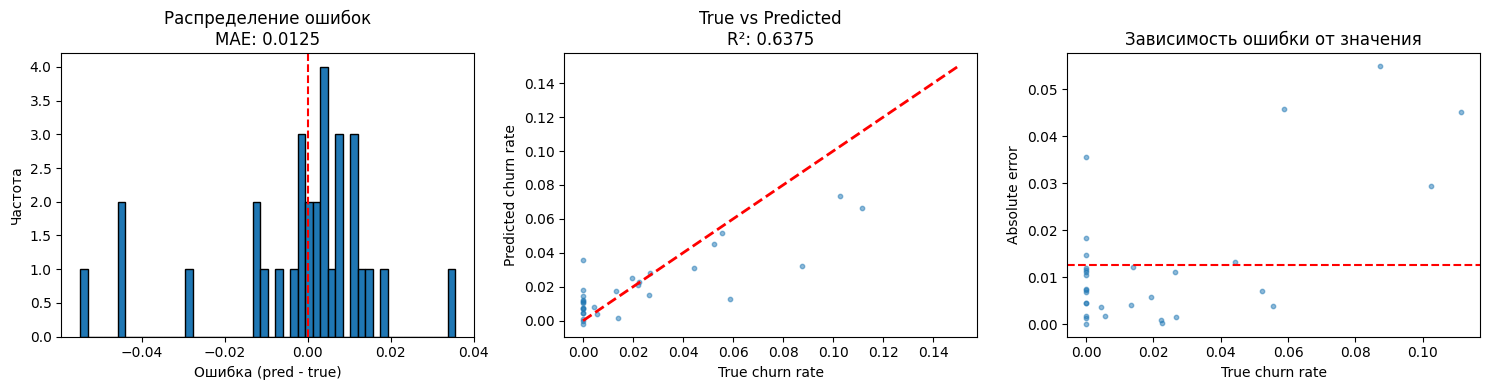


FINAL RESULTS

model  val_rmse  test_rmse  test_mae
  GNN  0.017852   0.018939  0.012524

🏆 Best: GNN (Test RMSE: 0.0189)

✅ Для предсказаний сохранено:
   - edge_index.pt (структура графа)
   - node_features.csv (признаки узлов)
   - scaler_x.pkl (скалер признаков)
   - gnn_model.pth (модель)


(  model  val_rmse  test_rmse  test_mae
 0   GNN  0.017852   0.018939  0.012524,
 {'result': {'model': 'GNN',
   'val_rmse': 0.01785181276500225,
   'test_rmse': 0.018938880413770676,
   'test_mae': 0.012523849494755268},
  'features_raw':                                   steps_count  sessions_count   steptime_ms  \
  node_id                                                                       
  0072f89b60d46ef6f2094949d8831f13       122981           74914  6.332178e+04   
  02b207cc24a78c1942161bafc72fe532        80796           71489  1.126068e+06   
  05084b69eadb4959371691236de248f0            6               6  7.489565e+04   
  05aa62cfe2beb31d4ecc652cddec5689           13              12  5.490000e+05   
  061da77ad7d449a342174810fbf72350            7               6  1.333000e+06   
  ...                                       ...             ...           ...   
  f2f9d242858a788cad0cd1e66264f25b         3119            2737  4.123037e+04   
  f38e3fd9c83a13ec4cc1da34306c886

In [48]:
run_all_single()

## Предсказание

In [49]:
import pickle

def load_vectorizer(filename='tfidf_vectorizer.pkl'):
    with open(filename, 'rb') as f:
        vectorizer = pickle.load(f)
    print(f"Vectorizer загружен из {filename}")
    print(f"Размер словаря: {len(vectorizer.vocabulary_)}")
    return vectorizer

def load_gnn_for_predictions(save_dir, device="cpu"):
    """
    Загружает всё необходимое для предсказаний
    """
    # 1. Модель
    checkpoint = torch.load(os.path.join(save_dir, "gnn_model.pth"), map_location=device)
    model = GraphSAGEChurn(
        in_channels=checkpoint["config"]["in_channels"],
        hidden_channels=checkpoint["config"]["hidden_channels"],
        num_layers=checkpoint["config"]["num_layers"],
        dropout=checkpoint["config"]["dropout"],
    ).to(device)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    
    # 2. Scaler
    scaler_x = joblib.load(os.path.join(save_dir, "scaler_x.pkl"))
    
    # 3. Edge index
    edge_index = torch.load(os.path.join(save_dir, "edge_index.pt"), map_location=device)
    
    # 4. Mapping (опционально)
    import json
    with open(os.path.join(save_dir, "node_mapping.json"), "r") as f:
        mapping = json.load(f)

    vectorizer = load_vectorizer(os.path.join(SAVE_DIR, "tfidf_vectorizer.pkl"))
    
    return {
        "model": model,
        "scaler_x": scaler_x,
        "edge_index": edge_index,
        "node_id_to_idx": mapping["node_id_to_idx"],
        "all_ids": mapping["all_ids"],
        "vectorizer": vectorizer,
    }

## Предсказание по новой ноде

In [50]:
def predict_new_nodes(model, scaler_x, edge_index, new_features_df, device="cpu"):
    """
    Предсказание для новых узлов
    
    new_features_df: DataFrame с колонками как в features (без churn_rate)
                    индекс - node_id
    """
    # Конвертируем в numpy
    X_new = new_features_df.values
    
    # Скалируем
    X_new_scaled = scaler_x.transform(X_new)
    
    # В тензор
    x_tensor = torch.tensor(X_new_scaled, dtype=torch.float).to(device)
    
    # Edge_index остается тем же (если структура графа не меняется)
    
    # Предсказание
    with torch.no_grad():
        predictions = model(x_tensor, edge_index)
        predictions = predictions.cpu().numpy().flatten()
    
    # Создаем DataFrame с результатами
    results_df = pd.DataFrame({
        "node_id": new_features_df.index,
        "predicted_churn_rate": predictions
    })
    
    return results_df

def build_node_text_embedding(screen, feature, action, vectorizer):
    text = f"{screen} {feature} {action}"
    vec = vectorizer.transform([text]).toarray()
    return vec.squeeze()  # (64,)


In [53]:
# Для предсказаний на тех же узлах:
loaded = load_gnn_for_predictions(SAVE_DIR, device="cpu")

model = loaded["model"]
scaler_x = loaded["scaler_x"]
edge_index = loaded["edge_index"].clone()
vectorizer = loaded["vectorizer"]
model.eval()

# Загружаем признаки
features_df = pd.read_csv(os.path.join(SAVE_DIR, "node_features.csv"), index_col="node_id")

screen='Еще'
feature='Открытие экрана'
action="Переход к экрану"

# screen='Дополнительно'
# feature='Выйти из приложения'
# action="Тап на кнопку 'Выйти из приложения'"

# screen='Важное'
# feature='Выбор квартиры'
# action="Тап на кнопку 'Обращение к администратору'"

# TODO: переделать на SentenceTransformer
text_emb = build_node_text_embedding(
    screen, feature, action, vectorizer
).astype(np.float32)

mean_features = features_df.mean()
# new_node_df = pd.DataFrame([mean_features], columns=features_df.columns)

new_node = mean_features.copy()

# подставляем текст
for i, v in enumerate(text_emb):
    new_node[f"text_emb_{i}"] = v

new_node_df = pd.DataFrame([new_node], columns=features_df.columns)


X_old = features_df.values
X_new = new_node_df.values

X_all = np.vstack([X_old, X_new])

# ВАЖНО: только transform
X_all_scaled = scaler_x.transform(X_all)

x_tensor = torch.tensor(X_all_scaled, dtype=torch.float)

# TODO: добавить связь новой ноды, с какойнибудь случайной нодой уже существующей
edge_index = loaded["edge_index"]

# Добавляем ребро к случайной существующей ноде
num_old_nodes = features_df.shape[0]
new_node_idx = num_old_nodes

# existing_node_idx = np.random.randint(0, num_old_nodes)
existing_node_idx = 10

# добавляем ребра (undirected)
new_edges = torch.tensor(
    [
        [existing_node_idx, new_node_idx],
        [new_node_idx, existing_node_idx],
    ],
    dtype=torch.long
).t()

edge_index_extended = torch.cat([edge_index, new_edges], dim=1)

# Предсказание
with torch.no_grad():
    out = model(x_tensor, edge_index_extended)

new_node_prediction = out[new_node_idx].item()

print(f"Predicted churn_rate for new node: {new_node_prediction:.6f}")

Vectorizer загружен из ../../data/graph-save/tfidf_vectorizer.pkl
Размер словаря: 64
Predicted churn_rate for new node: 0.020912
